# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

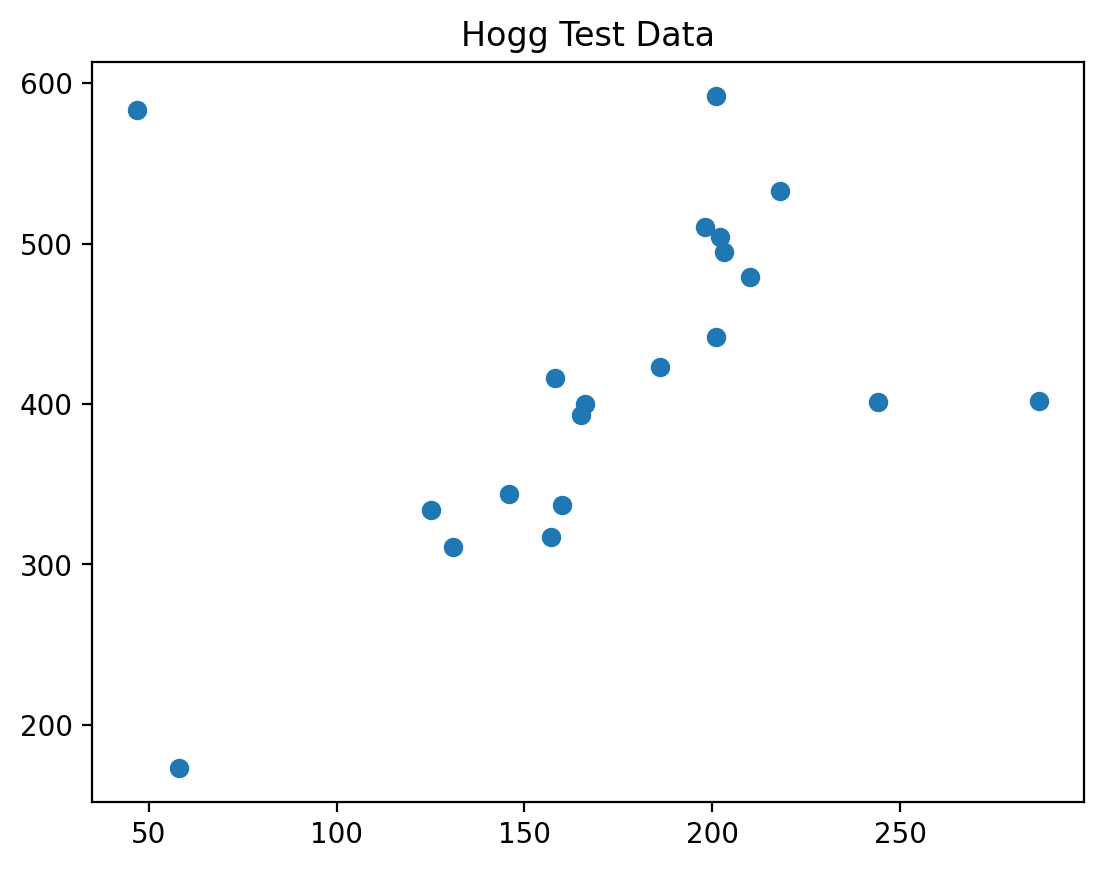

In [3]:
# quick look at the data
plt.title("Hogg Test Data")
plt.scatter(x,y)
plt.show()

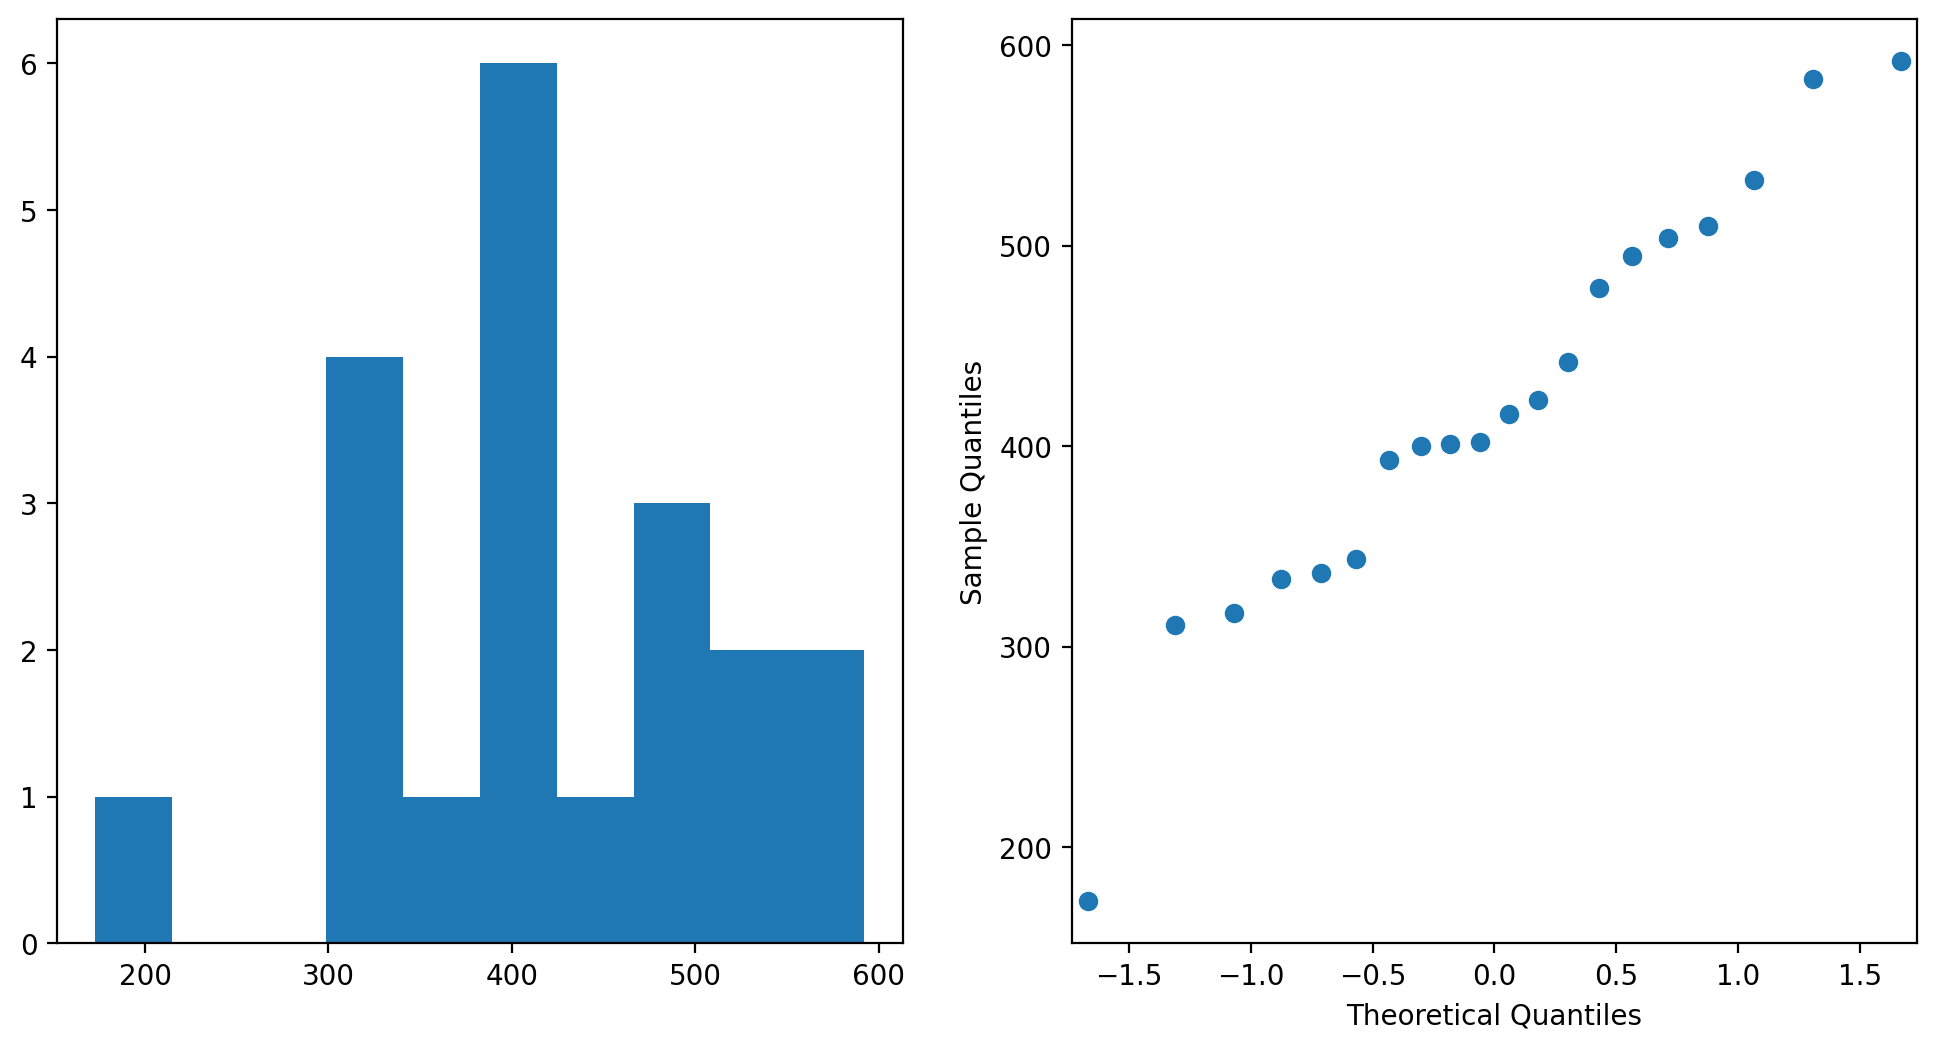

In [4]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.hist(y) # gauss-ish?
ax2 = fig.add_subplot(122)
sm.qqplot(y,ax=ax2)
plt.show()

In this case, we want to minimize with respect to the model parameters, $a$ and $b$.

The simple cost function for this problem: $\rho(u) = u^2$, where $u = y_i - M(a,b,x_i)$, where $M(x_i)$ is our model for the data, which we are taking to be linear.

The squared loss is computed as follows: $\chi^2 = \sum_{i=1}^N \bigg(\frac{y_i - M(a,b,x_i)}{\sigma_i}\bigg)^2 = \sum_{i=1}^N \bigg(\frac{u}{\sigma_i}\bigg)^2 \sum_{i=1}^N \rho (u)\bigg(\frac{1}{\sigma_i}\bigg)^2$



In [5]:
# computing the chi squared/squared loss - ask if these are the same
def squared_loss(x,y,dy,model_params):
    
    (a,b) = model_params
    def model(a,b,x):
        return a*x + b
    
    f_x = model(a,b,x)
    return (((y - f_x) / dy)**2).sum() # does this need the 1/2

Now, a line can be fit to the data by finding $a,b$ that minimize the squared loss.

To do this, we will make a grid of points (a,b) and locate the one that provides the smallest loss.

Eyeballing the scatter plot above, I am going to guess $b = 75$ and $a = 1$, then probe values near this area.

In [6]:
def grid_search(x,y,dy,guess):
    (a_est, b_est) = guess
    grid_a, grid_b = np.mgrid[a_est*0.5:a_est*3:a_est/5, b_est*0.5:b_est*2:b_est/15] # there must be a better way

    # make an empty matrix to hold points - each column is a (x,y) coord
    pos = np.empty(grid_a.shape + (2,)) # 3D matrix
    pos[:,:,0] = grid_a; pos[:,:,1] = grid_b

    min_chi = np.inf # largest possible value, so 1st value will reset this
    best_parameter = (0,0) # placeholder

    # loop through the points
    for col in pos:
        for pt in col:
            param_guess = (pt[0], pt[1]) # (a,b)

            # find the parameters that give the smallest chi**2
            loss = squared_loss(x,y,dy,param_guess)
            if loss < min_chi:
                min_chi = loss
                best_parameter = param_guess

    print(min_chi)
    return best_parameter

print("Grid Search chi and model parameters", grid_search(x,y,dy, (1,75))) # grid search results
print("Squared loss of my guess", squared_loss(x,y,dy,(1,75))) # chi of my guess
# there is improvement

319.93972599535465
Grid Search chi and model parameters (1.5, 137.5)
Squared loss of my guess 1353.1809508880117


Plotting this line onto the data:

319.93972599535465


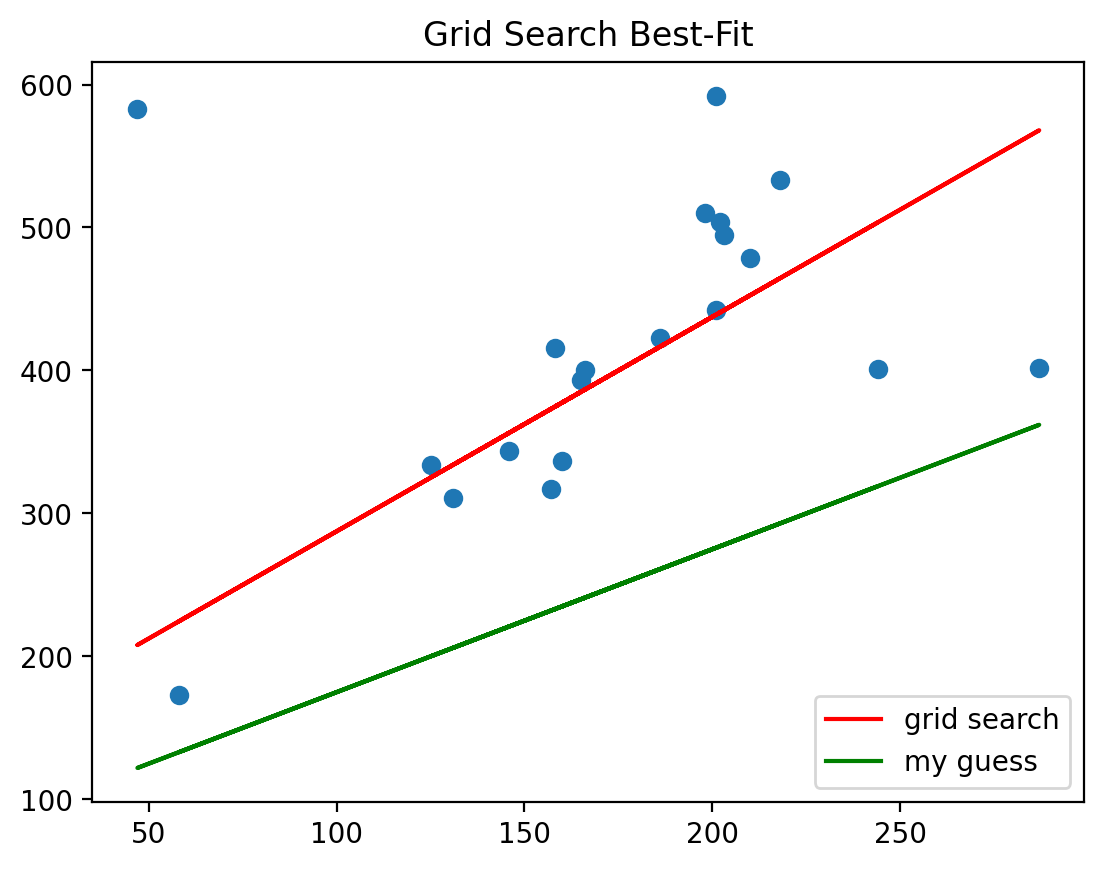

In [7]:
best_parameter = grid_search(x,y,dy, (1,75))
a = best_parameter[0]
b = best_parameter[1]
yvals = a*x + b
yvals_fail = x + 75

plt.scatter(x,y)
plt.plot(x,yvals,c='r',label="grid search")
plt.plot(x,yvals_fail,c='g',label="my guess")
plt.title("Grid Search Best-Fit")
plt.legend()
plt.show()

The grid searched parameters fit much better than my guess.

There are some strong outliers here that seem to be impacting the line fit still, so I will use sigma-clipping to reject these outliers.

## I think issues are coming from here

In [8]:
# clip points that are n sigma away from the mean until the difference 
    # between the old and new moments are smaller than epsilon
    
# must I clip from distance from (x-mu, y_mu)??? - something not right here
def sigma_clip(x,y):
    
    while True:
        y_mu = y.mean()
        y_sigma = y.std()
    
        epsilon = 0.0001 # the difference threshold
        
        # find the indices of the items that meet the criterion
        idx = np.where(np.abs(y - y_mu) < 2*y_sigma)
        y_clipped = y[idx]
        x_clipped = x[idx]
        diff = [np.abs(y_clipped.mean()-y_mu), np.abs(y_clipped.std()-y_sigma)]
        
        print(diff)
        if (np.abs(y_clipped.mean()-y_mu) < epsilon) and (np.abs(y_clipped.std()-y_sigma) < epsilon):
            break
        else:
            x = x_clipped
            y = y_clipped
       
    return idx # return the non-rejected indices

[12.97105263157897, 15.43271372805222]
[0.0, 0.0]
319.6168954168422
(1.5, 137.5)


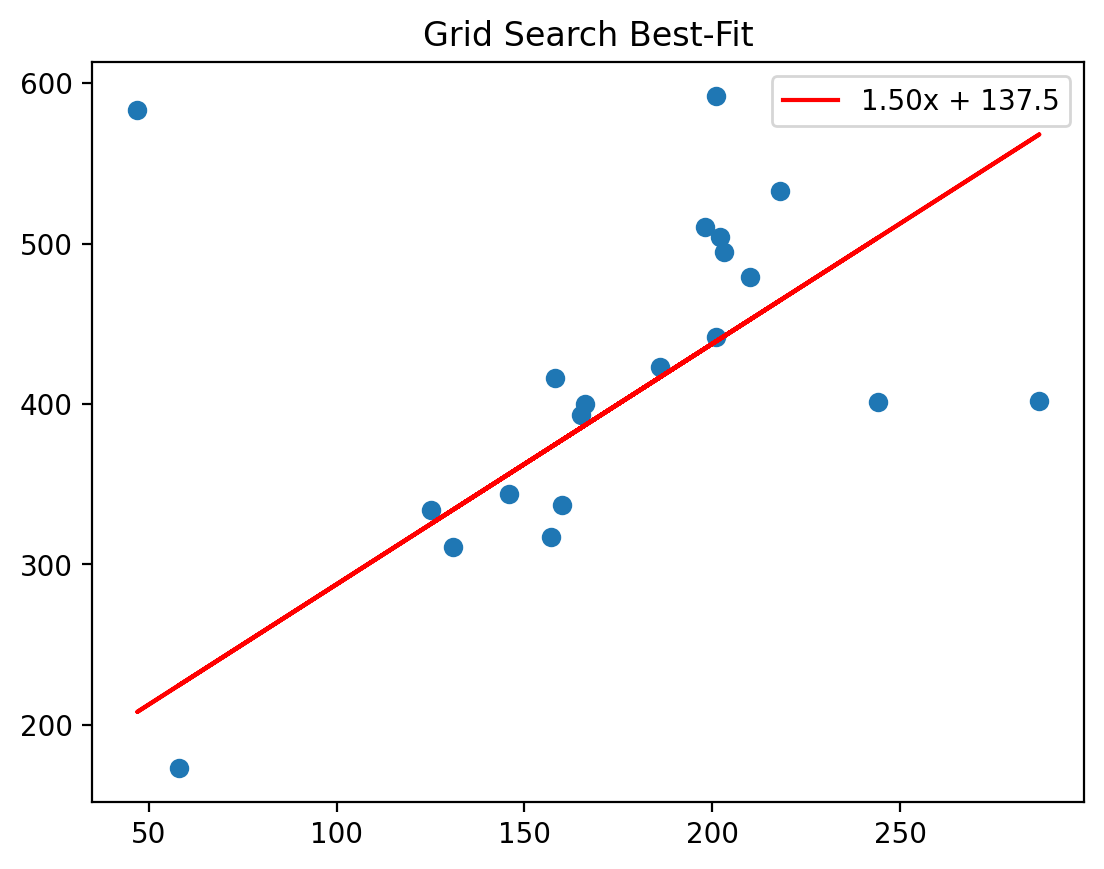

In [9]:
idx = sigma_clip(x,y)

# refittinng on the clipped data
best_parameter = grid_search(x[idx],y[idx],dy[idx], (1,75))
a = best_parameter[0]
b = best_parameter[1]
print(best_parameter)
yvals = a*x + b

plt.scatter(x,y)
plt.plot(x,yvals,c='r', label="%.2fx + %.1f"%(a,b))
plt.title("Grid Search Best-Fit")
plt.legend()
plt.show()

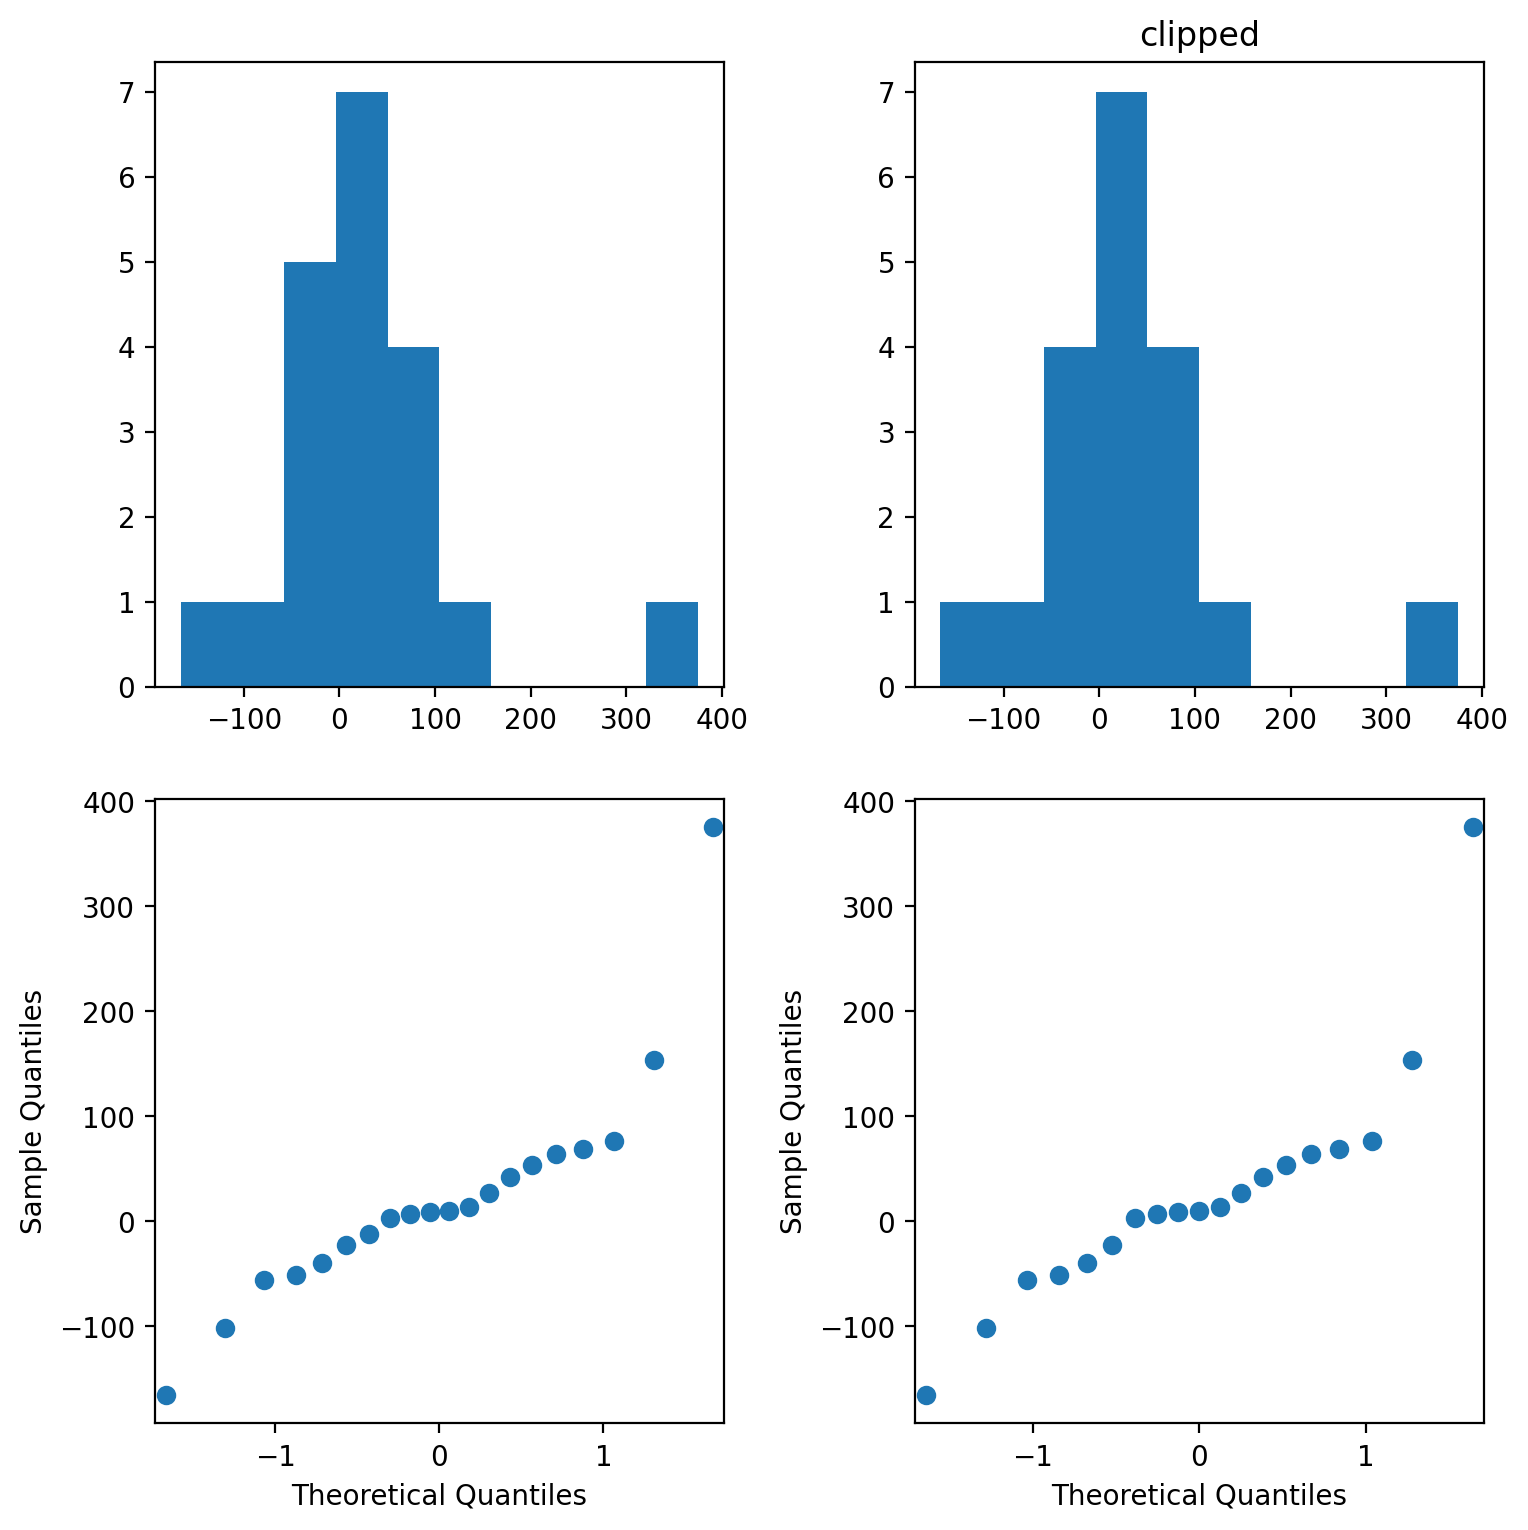

In [10]:
# residuals 
residuals = y - (a*x + b) # subtract the model from the data
residuals_c = y[idx] - (a*x[idx] + b) # clipped residuals

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(221)
ax.hist(residuals)
ax2 = fig.add_subplot(222)
ax2.hist(residuals_c)
ax2.set_title("clipped")

ax3 = fig.add_subplot(223)
sm.qqplot(residuals,ax=ax3)

ax4 = fig.add_subplot(224)
sm.qqplot(residuals_c,ax=ax4)

fig.tight_layout(pad=2)
plt.show()

The clipped distribution looks a bit more gaussian that the raw data.

155.0
155.0


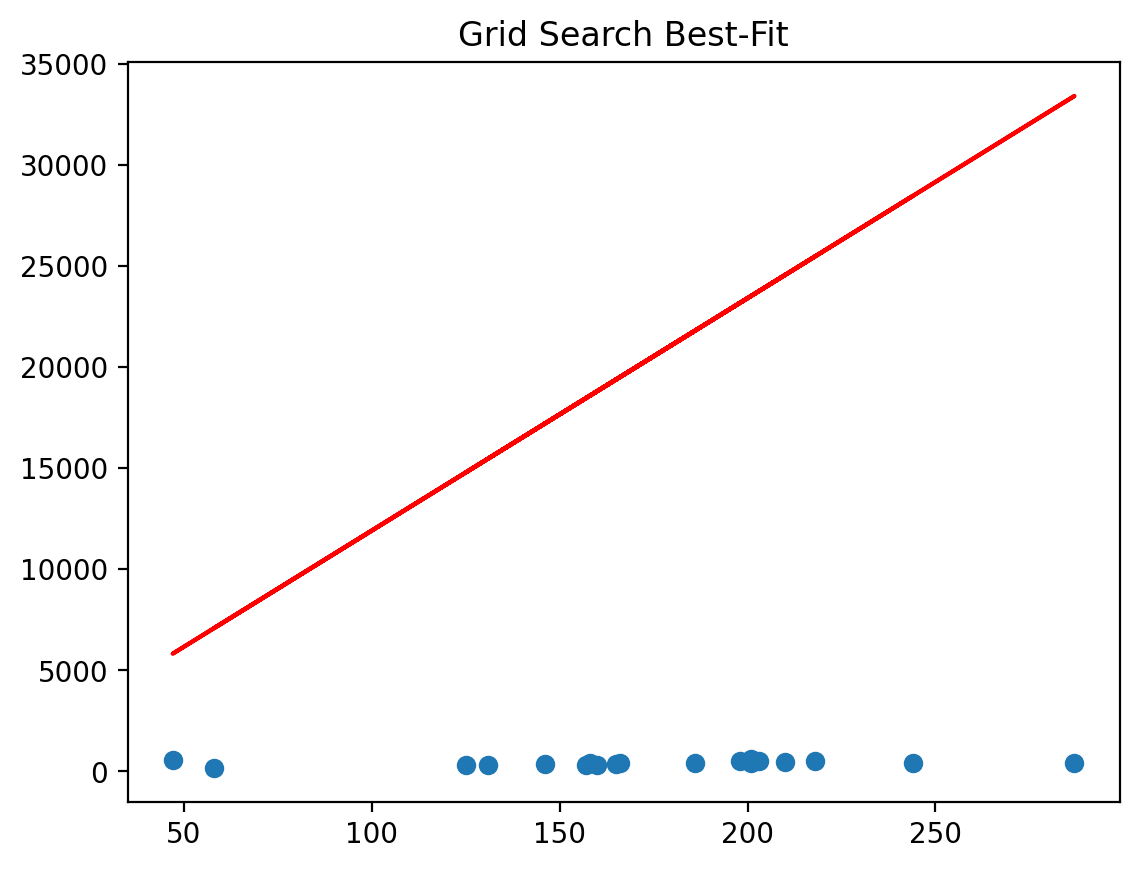

In [11]:
import scipy.stats as sts

# IQR clipping
def L_estimator_IQR(x,y):
    q25 = np.percentile(y, 25)
    q75 = np.percentile(y, 75)
    iqr = q75 - q25
    print(iqr)
    x25 = sts.norm.ppf(0.25)
    x75 = sts.norm.ppf(0.75)
    print(iqr)
    
    return q25 + (iqr/(x75-x25))*(x-x25)

plt.scatter(x,y)
yvals = L_estimator_IQR(x,y)
plt.plot(x,yvals,c='r')
plt.title("Grid Search Best-Fit")
plt.show()

In [12]:
# computing the chi squared/squared loss - ask if these are the same
    # uses x,y,dy from above
def huber_loss_squared(model_params, x, y, dy, delta):
    #delta = 0.2
    (a,b) = model_params
    def model(a,b,x):
        return a*x + b
    
    M_x = model(a,b,x)
    
    u = y - M_x
    cost = np.array([0.5*u**2 if np.abs(u) <= delta else delta*(np.abs(u) - 0.5*delta) for u in u])
    
    # sum the cost squared and incorperate the uncertainty
    if dy == []: # ??
        return cost.sum()
    return (cost * dy**-2).sum()

opt_param = scipy.optimize.fmin(huber_loss_squared, x0=(1,75), args=(x,y,dy,0.2))
opt_param

Optimization terminated successfully.
         Current function value: 0.487600
         Iterations: 63
         Function evaluations: 123


C:\Users\Haille Perkins\AppData\Local\Temp\ipykernel_15420\1299426686.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if dy == []: # ??


array([ 2.05513677, 53.91086368])

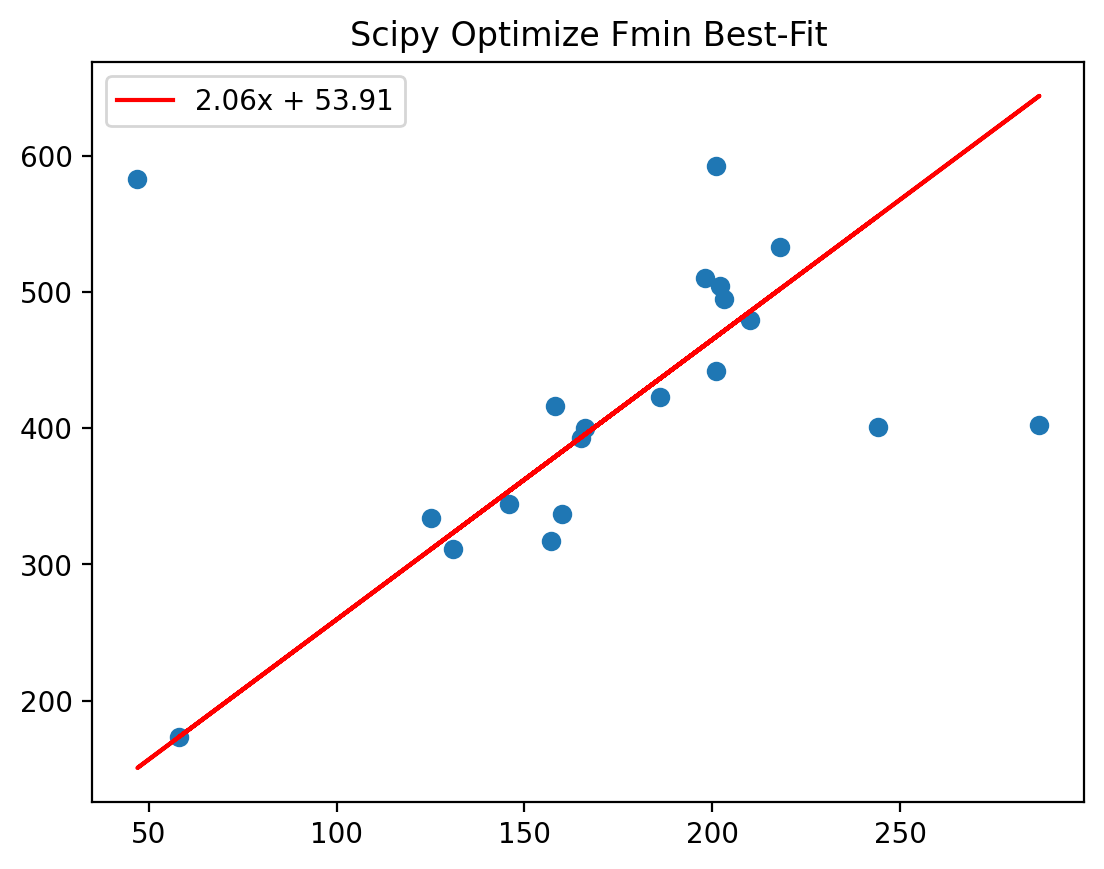

In [13]:
#a = opt_param[0]
#b = opt_param[1]
[a,b] = opt_param
plt.scatter(x,y)
yvals = a*x + b
plt.plot(x,yvals,c='r', label="%.2fx + %.2f"%(a,b))
plt.title("Scipy Optimize Fmin Best-Fit")
plt.legend()
plt.show()

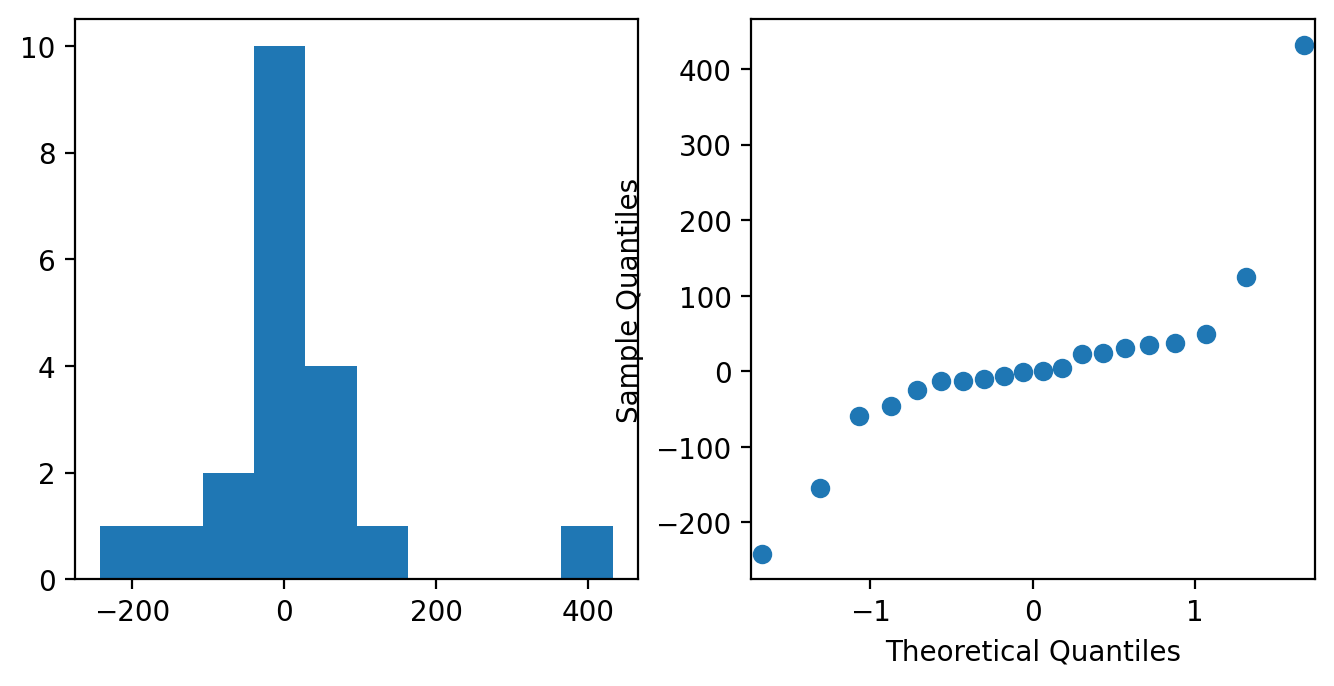

In [14]:
# residuals 
residuals = y - (a*x + b) # subtract the model from the data

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(221)
ax.hist(residuals)
ax2 = fig.add_subplot(222)
sm.qqplot(residuals, ax=ax2)

plt.show()

The fit looks better, but there are still a few outlier, but the QQplot is much more linear than before.

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [15]:
import pandas as pd

# preview the data
cepheids = pd.read_csv('Cepheids.csv')
cepheids[:5]

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
0,OGLE-LMC-CEP-0002,4.529733,-69.81933,F,LMC,14.52500,0.493893,0.740
1,OGLE-LMC-CEP-0005,4.592089,-69.73497,F,LMC,13.49540,0.749122,0.752
2,OGLE-LMC-CEP-0012,4.630203,-67.21442,F,LMC,14.54210,0.424912,0.598
3,OGLE-LMC-CEP-0016,4.642367,-67.64631,F,LMC,12.03300,1.021456,1.080
4,OGLE-LMC-CEP-0017,4.649119,-69.68839,F,LMC,14.34215,0.565524,0.647


In [16]:
# split the data
LMC_F = cepheids[(cepheids['Cloud']=='LMC') & (cepheids['Mode']=='F')]
LMC_1 = cepheids[(cepheids['Cloud']=='LMC') & (cepheids['Mode']=='1')]
SMC_F = cepheids[(cepheids['Cloud']=='SMC') & (cepheids['Mode']=='F')]
SMC_1 = cepheids[(cepheids['Cloud']=='SMC') & (cepheids['Mode']=='1')]

#assert(len(cepheids) == len(LMC_F)+len(SMC_F)+len(LMC_1)+len(SMC_1))

In [17]:
# I assume the residual are note going to be normally distributed bc stars are silly - can only see brightest ones far away,light is logrithmic scaling

In [18]:
titles = []
datas = []
for c in ['LMC', 'SMC']:
    for m in ['F', '1']:
        titles.append(c+', '+m)
        datas.append(cepheids[(cepheids['Cloud']==c) & (cepheids['Mode']==m)])

Optimization terminated successfully.
         Current function value: 11.312888
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: 8.296653
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 36.316879
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 24.766247
         Iterations: 44
         Function evaluations: 84


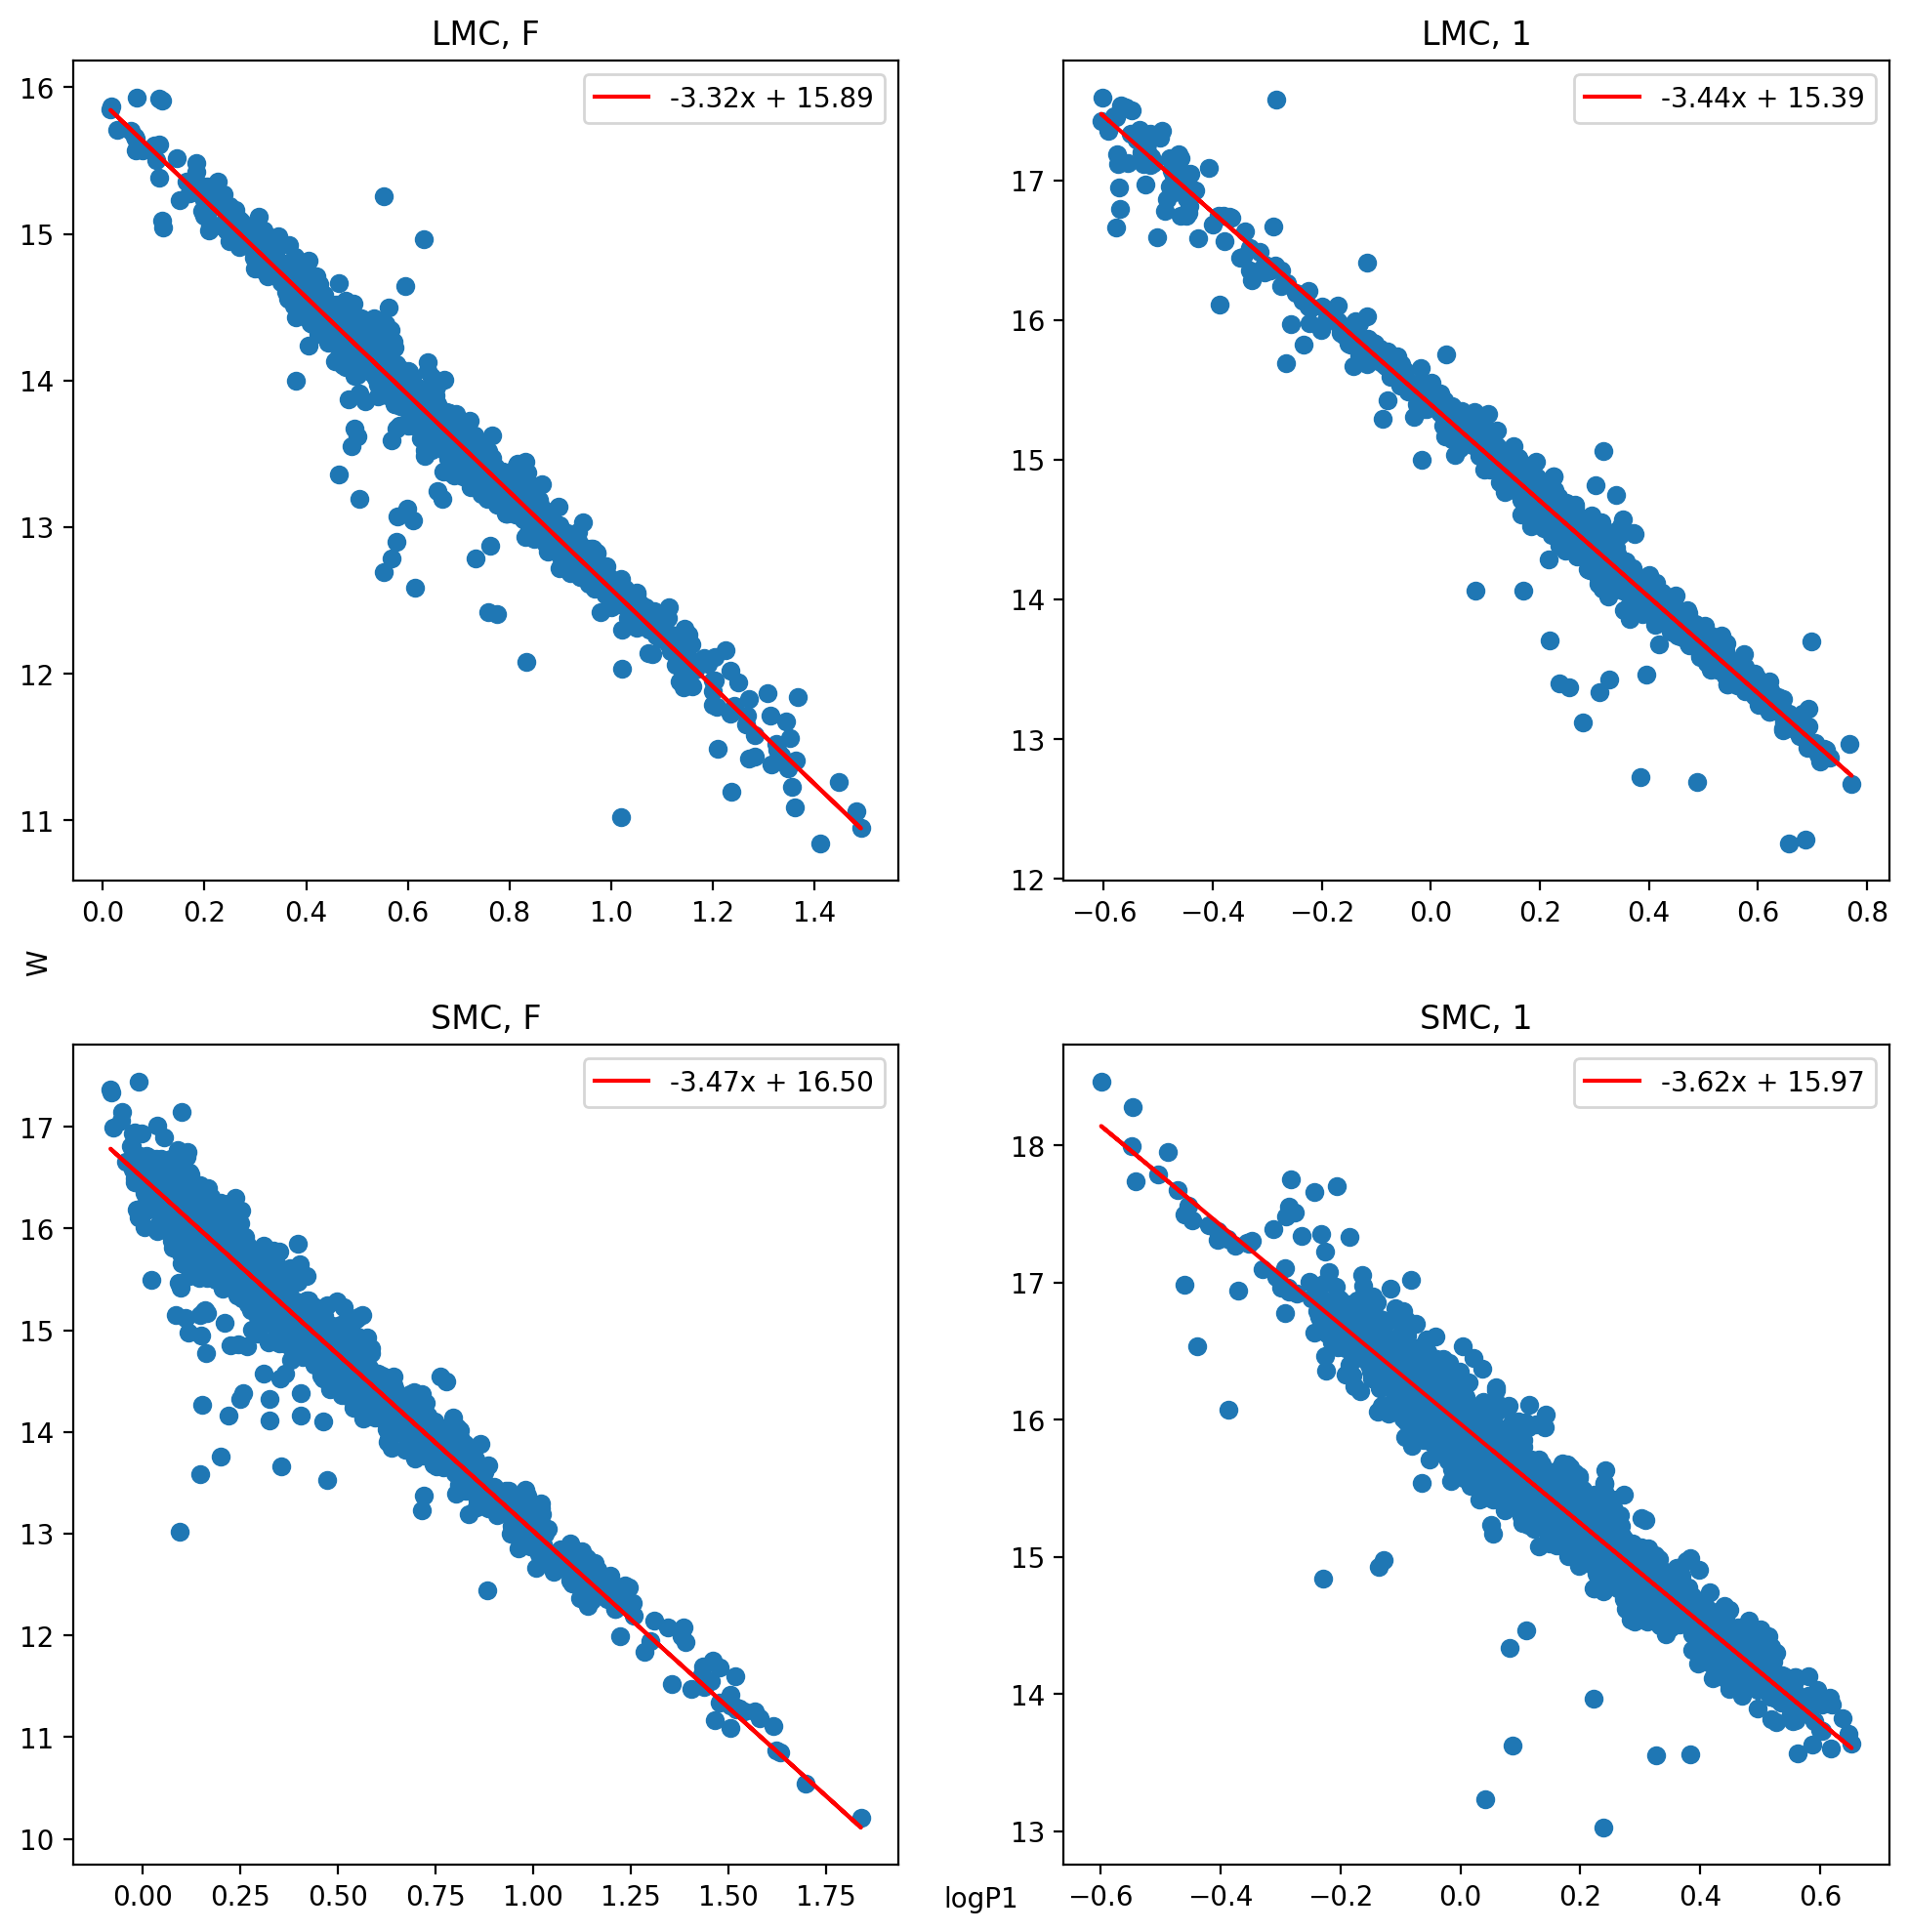

In [25]:
fig = plt.figure(figsize=(12,12))
ax_l = fig.add_subplot(111, frame_on=False)
ax_l.set_xlabel("logP1")
ax_l.set_ylabel("W")
ax_l.set_yticks([])
ax_l.set_xticks([])
guess = [(-3.6, 16), (-3.75,18), (-4,18), (-3.5,19)]
residuals = [0,0,0,0]
for i, d in enumerate(datas):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_title(titles[i])
    x = d['logP1']
    y = d['W']
    ax.scatter(x, y)
    [a,b] = scipy.optimize.fmin(huber_loss_squared, x0=guess[i], args=(x,y,[],0.2)) # make dy empty? - check if that is valid to just not include it
    yvals = a*x + b
    ax.plot(x,yvals, c='r', label="%.2fx + %.2f"%(a,b))
    residuals.append(y - yvals)
    plt.legend()
#fig.set_ylabel()

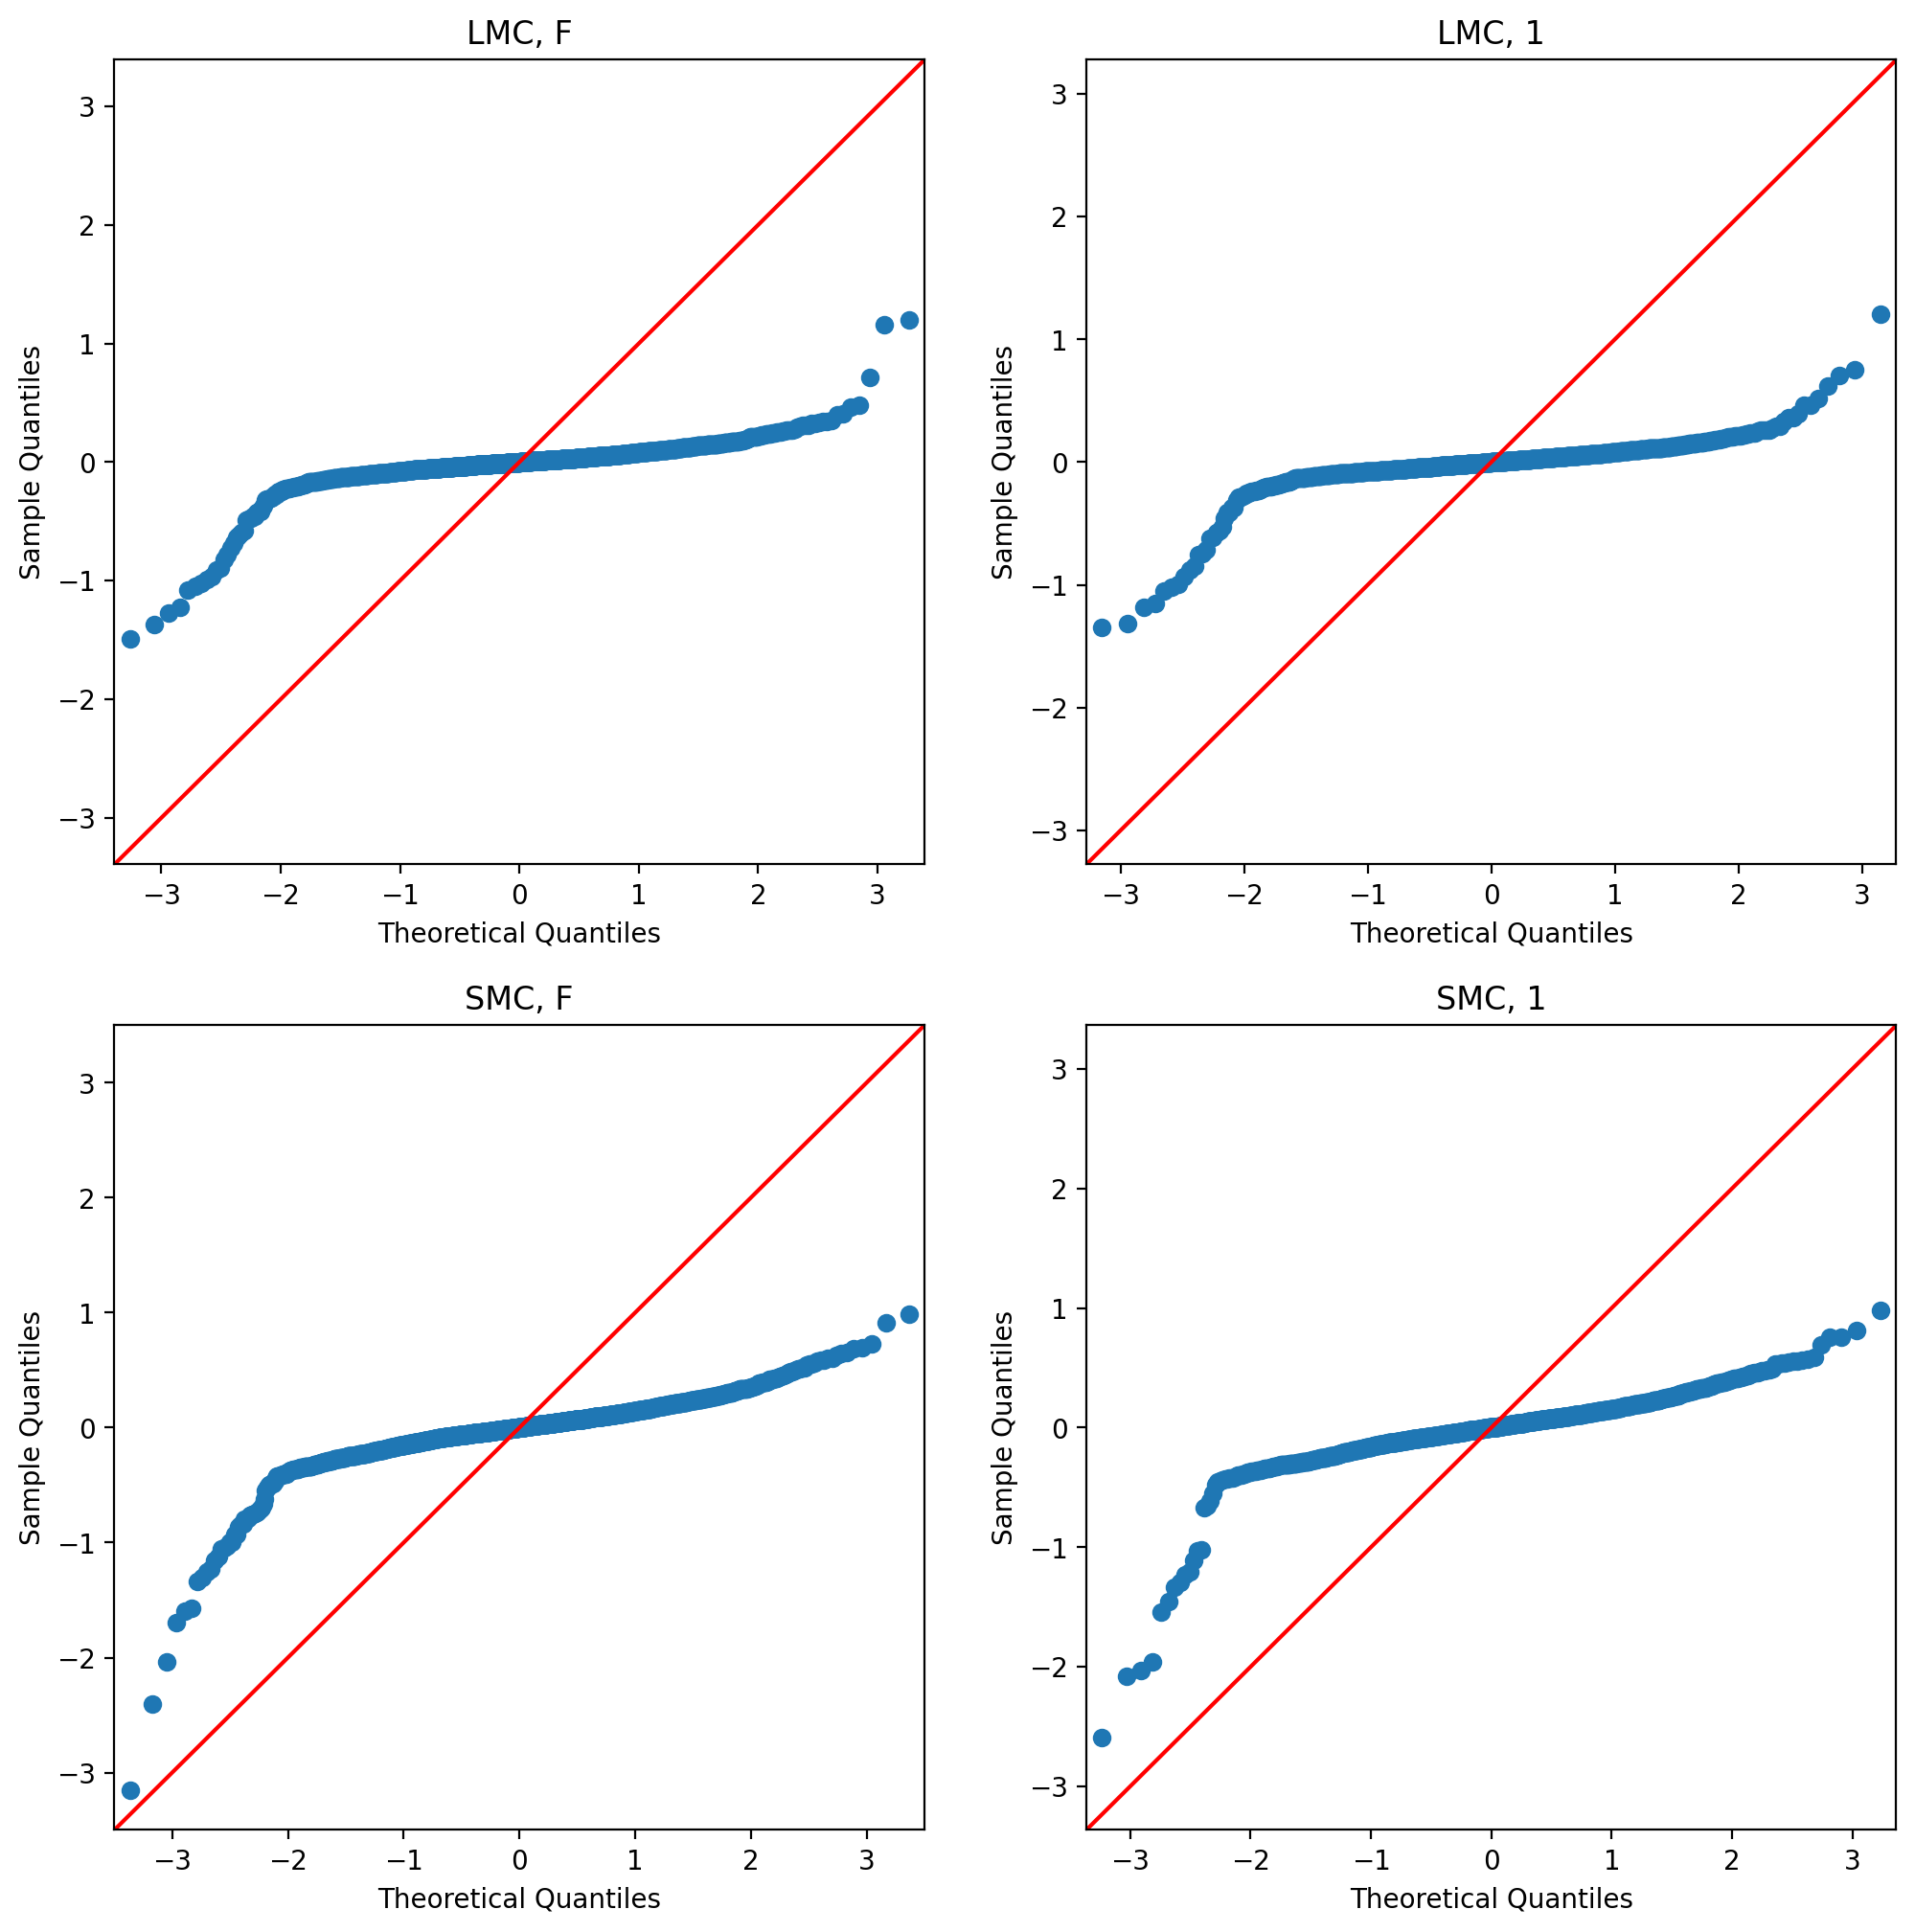

In [30]:
fig = plt.figure(figsize=(12,12))
for i, r in enumerate(residuals):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_title(titles[i])
    sm.qqplot(r,ax=ax,line='45')

These residuals do not seem to follow a normal distribution. This could be due to [insert thoughts]